### Note: this method works differently than LDA. Instead, it calculates similarity between documents based on a matrix of word_occurence by document, then cluster by using dimension reduction. LDA works with probabilities.

# Imports

In [66]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime
import os, sys

#sklearn for counting occurences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Gensim
import gensim
from gensim.utils import simple_preprocess

# spacy for lemmatization
import spacy

# unidecode
import unidecode as UN

#SQLalchemy for database
from sqlalchemy import create_engine

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.corpus import names
from stop_words import get_stop_words

# add any wanted stopwords here
name_list = names.words('male.txt') + names.words('female.txt')
name_list = [UN.unidecode(name.lower()) for name in name_list]
en_stop = get_stop_words('en') + get_stop_words('fr') + name_list + ['volume', 'issue', 'magazine', 'article', 'doi', 'preprint',
                                                                    'introduction', 'background', 'result', 'results','conclusion', 'conclusions',
                                                                    'limitations', 'acknowledgements','biorxiv', 'peer', 'review', 'fig',
                                                                    'figure', 'image', 'copyright', 'publication', 'author', 'authors', 'publish', 'editor'] 

stop_words.extend(en_stop)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from tqdm import tqdm_notebook as tqdm
import yake

import umap
import hdbscan
from faerun import Faerun, host
from matplotlib import colors

# Reads data

In [67]:
## TBIncluded in a config file
engine = create_engine('sqlite:///DB/papers_DB_HIVMalawi.db')
mallet_path = os.getcwd() + '/Mallet/mallet-2.0.8/bin/mallet'

### Gets parameters for the DB
print('Reading file')
query = "SELECT * FROM Complete;" 
start_time = datetime.now()
# Reads the data
dataFrame = pd.read_sql(query, engine).dropna(subset=['Full text']).drop(columns = ['level_0']).reset_index().drop(columns = ['level_0'])
dataFrame = dataFrame[['Title', 'Date', 'DOI', 'PMCID', 'PMID', 'PaperityID', 'arXID', 'Authors', 'Abstract', 'Full text', 'URL']]
dataFrame.columns = ['Title', 'Date', 'DOI', 'PMCID', 'PMID', 'PaperityID', 'arXID', 'Authors', 'Abstract', 'Full_text', 'URL']
dataFrame['Authors'] = dataFrame['Authors'].str.replace(';',', ')

Reading file


# Cleans some stuff

In [68]:
# Convert to list
data = dataFrame.Full_text.values.tolist()
# Test with first 1000 => Make sure you change the number also in format_topics_sentences
data = data[:1000]
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
# Remove http remnants in the text
data = [re.sub(r'^http?.*[\r\n]*', '', sent) for sent in data]
# Remove www remnants in the text
data = [re.sub(r'^www?.*[\r\n]*', '', sent) for sent in data]


#Gensim possess an optimised preprocessing tool that can remove punctuation as well
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
#print(data_words[:1])

# Build the bigram and trigram models

In [69]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

# Define functions for stopwords, bigrams, trigrams and lemmatization

In [70]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Applies the aforementionned functions

In [71]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = remove_stopwords(data_lemmatized)

In [72]:
data_lemmatized_2 = [' '.join(x) for x in  data_lemmatized]

# Creates a matrice of word occurence by document

#### First with a classical counting

In [73]:
# Here, even of we cleaned the text,
countVectorizer = CountVectorizer()
matrix_count = countVectorizer.fit_transform(data_lemmatized_2)

display(pd.DataFrame(matrix_count.toarray(), columns=countVectorizer.get_feature_names()).transpose()) 
#To look into the vectors. Beware, can take a bit of RAM

0    1    2    3    4    5    6    7    8    9    ...  990  \
a_r                0    0    0    0    0    0    0    0    0    0  ...    0   
aa                 0    0    0    0    0    0    0    0    0    0  ...    0   
aaaextracte        0    0    0    0    0    0    0    0    0    0  ...    0   
aabb               0    0    0    0    0    0    0    0    0    0  ...    0   
aabcsa             0    0    0    0    0    0    0    0    0    0  ...    0   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
zusammenfassung    0    0    0    0    0    0    0    0    0    0  ...    0   
zwaan              0    0    0    0    0    0    0    0    0    0  ...    0   
zwerle             0    0    0    0    0    0    0    0    0    0  ...    0   
zyome              0    0    0    0    0    0    0    0    0    0  ...    0   
zzy                1    0    0    0    0    0    0    0    0    0  ...    0   

                 991  992  993  994  995  996  997  998  999  
a_r                0    0    0    0    0    0    0    0    0  
aa                 0    0    0    0    0    0    0    0    0  
aaaextracte        0    0    0    0    0    0    0    0    0  
aabb               0    0    0    0    0    0    0    0    0  
aabcsa             0    0    0    0    0    0    0    0    0  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  
zusammenfassung    0    0    0    0    0    0    0    0    0  
zwaan              0    0    0    0    0    0    0    0    0  
zwerle             0    0    0    0    0    0    0    0    0  
zyome              0    0    0    0    0    0    0    0    0  
zzy                0    0    0    0    0    0    0    0    0  

[45164 rows x 1000 columns]

#### Then with a TF-IDF toc compare

In [74]:
# Here, even of we cleaned the text,
tfidfVectorizer = TfidfVectorizer()
matrix_tfidf = tfidfVectorizer.fit_transform(data_lemmatized_2)

display(pd.DataFrame(matrix_tfidf.toarray(), columns=tfidfVectorizer.get_feature_names()).transpose()) 
#To look into the vectors. Beware, can take a bit of RAM

0    1    2    3    4    5    6    7    8    9    ...  \
a_r              0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
aa               0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
aaaextracte      0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
aabb             0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
aabcsa           0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
zusammenfassung  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
zwaan            0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
zwerle           0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
zyome            0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
zzy              0.003264  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                 990  991  992  993  994  995  996  997  998  999  
a_r              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
aa               0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
aaaextracte      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
aabb             0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
aabcsa           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
zusammenfassung  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
zwaan            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
zwerle           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
zyome            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
zzy              0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[45164 rows x 1000 columns]

# Performs LSA (latent semantic analysis) => contrarily to LDA, this is a linear approach

In [75]:
#A value of 100 for the number of components in the output is recommended (see https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
#A fixed random_state ensures the data is reproducible
SVD = TruncatedSVD(n_components=100, n_iter=10, random_state=42)

XSVD_count = SVD.fit_transform(matrix_count)
print(SVD.explained_variance_ratio_.sum())
XSVD_tfidf = SVD.fit_transform(matrix_tfidf)
print(SVD.explained_variance_ratio_.sum())
dSVD_count = pd.DataFrame(XSVD_count)
dSVD_tfidf = pd.DataFrame(XSVD_tfidf)

sSVD_count = dSVD_count[[0,1]]
sSVD_count.columns = ['x','y']

sSVD_tfidf = dSVD_tfidf[[0,1]]
sSVD_tfidf.columns = ['x','y']


0.884461899371855
0.42335327604322404


# Clustering

#### Count

UMAP(a=None, angular_rp_forest=True, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='cosine',
     metric_kwds=None, min_dist=0.001, n_components=2, n_epochs=None,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Mon Apr 27 20:41:44 2020 Finding Nearest Neighbors
Mon Apr 27 20:41:44 2020 Finished Nearest Neighbor Search
Mon Apr 27 20:41:44 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  30

<Figure size 720x720 with 0 Axes>

23


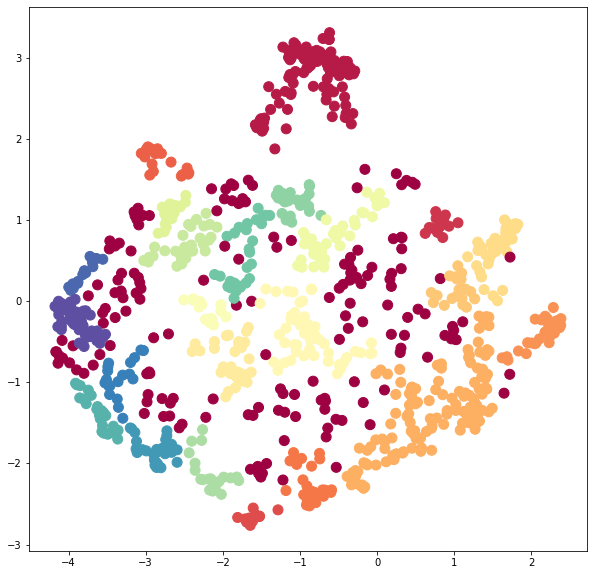

In [76]:
embedding_count = umap.UMAP(random_state=42,
                    n_components=2,
                    n_neighbors=50,
                    min_dist=0.001,
                    metric='cosine',
                    verbose=True).fit(XSVD_count)

plt.figure(figsize=(10,10))

clusterer_count = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=2).fit(embedding_count.embedding_)
plt.scatter(embedding_count.embedding_[:, 0], embedding_count.embedding_[:, 1], s=100, c=clusterer_count.labels_, cmap='Spectral')
col_len = len(set(clusterer_count.labels_))-1

print(col_len)

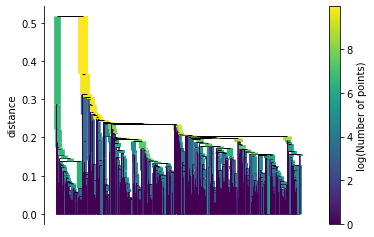

In [77]:
clusterer_count.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

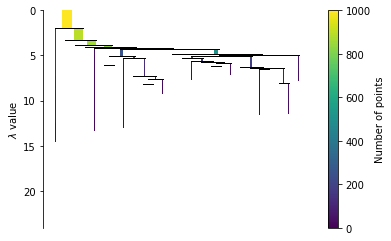

In [78]:
clusterer_count.condensed_tree_.plot()

#### TFIDF

UMAP(a=None, angular_rp_forest=True, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='cosine',
     metric_kwds=None, min_dist=0.001, n_components=2, n_epochs=None,
     n_neighbors=50, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Mon Apr 27 20:41:54 2020 Finding Nearest Neighbors
Mon Apr 27 20:41:54 2020 Finished Nearest Neighbor Search
Mon Apr 27 20:41:54 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  30

<Figure size 720x720 with 0 Axes>

27


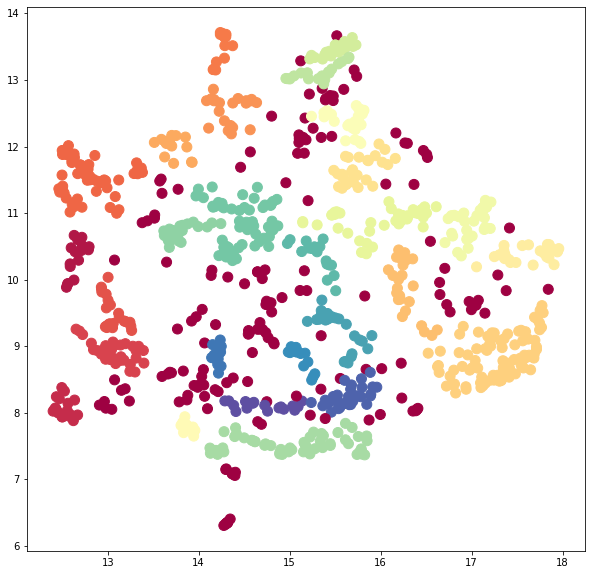

In [79]:
embedding_tfidf = umap.UMAP(random_state=42,
                    n_components=2,
                    n_neighbors=50,
                    min_dist=0.001,
                    metric='cosine',
                    verbose=True).fit(XSVD_tfidf)

plt.figure(figsize=(10,10))

clusterer_tfidf = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=2).fit(embedding_tfidf.embedding_)
plt.scatter(embedding_tfidf.embedding_[:, 0], embedding_tfidf.embedding_[:, 1], s=100, c=clusterer_tfidf.labels_, cmap='Spectral')
col_len = len(set(clusterer_tfidf.labels_))-1

print(col_len)

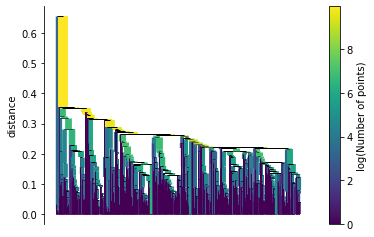

In [80]:
clusterer_tfidf.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

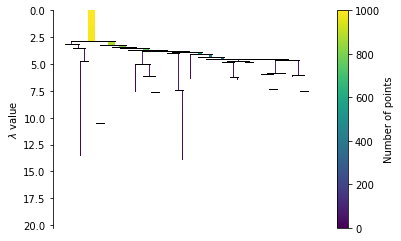

In [81]:
clusterer_tfidf.condensed_tree_.plot()

#### For further in this clustering, we keep the TFIDF one

# Labelling

In [82]:
dataFrame = dataFrame.iloc[:len(data)][:]
dataFrame['labels'] = 'noise'
dataFrame['text'] = data_lemmatized_2

for cluster_num in tqdm(range(0,col_len)):
    w = np.where(clusterer_tfidf.labels_==cluster_num)[0]
    text = ' '.join(dataFrame['text'][w])
    custom_kw_extractor = yake.KeywordExtractor(lan='en', n=1, dedupLim=0.7, dedupFunc='sqm', windowsSize=1, top=10, features=None)
    keywords = custom_kw_extractor.extract_keywords(text)

    kws = []
    for kw in keywords:
        kws.append(kw[1])
    dataFrame['labels'][w] = ', '.join(kws)
    
dataFrame = dataFrame.fillna('N/A')
dataFrame['tooltip'] = ('<b>Title: </b>' + dataFrame['Title'].str.upper() +
                    '</em>'+'<br><b>Authors: </b>'+dataFrame['Authors']+
                    '</em>'+'<br><b>Date: </b>'+dataFrame['Date']+
                    '</em>'+'<br><b>Abstract: </b>'+dataFrame['Abstract']+
                    '</em>'+'<br><b>DOI: </b>'+dataFrame['DOI']+
                    '<br><b>Cluster-Keywords: </b><em>'+dataFrame['labels'])

labels, uniques = pd.factorize(dataFrame['labels'])
dataFrame['cluster'] = labels
dataFrame['cluster'][np.where(dataFrame['labels']=='noise')[0]] = -1

col_len = len(list(dataFrame['cluster'])) - 1

dataFrame
pd.DataFrame(embedding_tfidf.embedding_).to_csv('to_cluster.csv',index=False)
to_cluster = pd.read_csv('to_cluster.csv')

/mnt/c/Users/thiabaud/Documents/Environments/ASR/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/mnt/c/Users/thiabaud/Documents/Environments/ASR/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Title     Date  \
0                            vol. 86, no. 4: fall 1997  1997-12   
1    \ndeterminants of retention in care in an anti...  2008-07   
2    playing the role of a 'boundary organisation':...  2011-06   
3    who will touch the 'dangerous women'? sinners ...  2006-01   
4    neither 'foolish' nor 'finished': identity con...  2016-12   
..                                                 ...      ...   
995  diagnosis of childhood tuberculosis and host r...  2014-06   
996  hypertension and associated factors in older a...  2013-04   
997           africa: the new family planning frontier  2002-03   
998  a descriptive analysis of perceptions of hiv r...  2014-09   
999  business ethics as field of teaching, training...  2011-01   

                              DOI    PMCID      PMID  PaperityID arXID  \
0    10.1371/journal.pone.0211619  6373965  30759138  8.1327e+07   N/A   
1                             N/A  2984267  21532891         N/A   N/A   
2      10.1186/1478-4505-9-S1-S11  3121128  21679378         N/A   N/A   
3                 10.2307_4066811      N/A       N/A         N/A   N/A   
4         10.1111/1467-9566.12531  6850051  28012191         N/A   N/A   
..                            ...      ...       ...         ...   ...   
995         10.1056/NEJMoa1303657  4069985  24785206         N/A   N/A   
996         10.5830/CVJA-2013-002  3721893  23736129         N/A   N/A   
997               10.2307_2696334      N/A       N/A         N/A   N/A   
998        10.7448/IAS.17.3.19152  4164016  25224613         N/A   N/A   
999              10.2307_41476060      N/A       N/A         N/A   N/A   

                                               Authors  \
0                                        College Colby   
1    Tsague Landry, Koulla Sinata S, Kenfak Alain, ...   
2                            Drimie Scott, Quinlan Tim   
3                                                  N/A   
4                                        Freeman Emily   
..                                                 ...   
995  Anderson Suzanne T., Kaforou Myrsini, Brent An...   
996                Peltzer Karl, Phaswana-Mafuya Nancy   
997                     Caldwell Pat, Caldwell John C.   
998  Corneli Amy L, McKenna Kevin, Headley Jennifer...   
999                               Rossouw Gedeon Josua   

                                              Abstract  \
0              By Colby College, Published on 07/18/16   
1    Background Retention in long-term antiretrovir...   
2    Background This paper discusses the practices ...   
3    \n             Looking at sex workers and at w...   
4    Abstract Prevalence of HIV after age 50 is con...   
..                                                 ...   
995  BACKGROUND Improved diagnostic tests for tuber...   
996  Background Older adults are disproportionately...   
997  \n             Sub-Saharan Africa will be the ...   
998  Introduction Risk perception is a core constru...   
999  \n             The article provides an overvie...   

                                             Full_text  \
0    Colby Magazine Volume  Issue  Fall   Article  ...   
1    Background With more than 60% of the world's H...   
2    Introduction This paper examines researchers' ...   
3     Who will touch the 'dangerous women'? Sinners...   
4    Introduction For more than 30 years, Human Imm...   
..                                                 ...   
995  Supplementary Appendix This appendix has been ...   
996  Abstract High blood pressure in South Africa i...   
997   Regional Perspectives Africa: The New Family ...   
998  Introduction An individual's perception of ris...   
999   J Bus Ethics (201 1) 104:83-92 DOI 10.1007/sl...   

                                                   URL  \
0    https://digitalcommons.colby.edu/cgi/viewconte...   
1                                                  N/A   
2                                                  N/A   
3                               

# Display

In [83]:
#pd.DataFrame(to_cluster.embedding_).to_csv('to_cluster.csv',index=False)

color_scale = ["#da7e8f",
                "#63b747",
                "#5587fc",
                "#a2ba34",
                "#008aeb",
                "#458704",
                "#d19aff",
                "#818900",
                "#017ac1",
                "#d16721",
                "#009e8d",
                "#f3a449",
                "#008140",
                "#9f4146",
                "#65c6a1",
                "#795b22",
                "#8ec195",
                "#cfb34e",
                "#2d6c49",
                "#a6be6d"]
    
cmap = colors.LinearSegmentedColormap.from_list('cmap',list(color_scale),len(list(color_scale)))

f_data = {'x': to_cluster['0'], 'y': to_cluster['1'],
          'c': dataFrame['cluster'],'labels': dataFrame['tooltip'].str.replace('[^\w\s:,!?\.<>\/-]', '').values}

In [87]:
to_cluster['0']

0      12.858773
1      15.888611
2      13.794066
3      14.109596
4      16.018152
         ...    
995    14.893162
996    15.090275
997    14.283356
998    15.982309
999    13.622718
Name: 0, Length: 1000, dtype: float64

In [90]:
f = Faerun(title='Test', clear_color='#fcf8f2',
           coords=True, scale= 1,
           view='front',alpha_blending=False,
           anti_aliasing=True)

f.add_scatter('econ', f_data)#,  colormap='viridis', saturation_limit = 0.4, max_point_size=13,
#               point_scale=1.2, shader="smoothCircle", fog_intensity=1,
#                 categorical=True)

f.plot('econ')

f.add_scatter('econ2', {'x': np.array([-20,20,20,-20]), 'y': np.array([-20,-20,20,20]),
            'c': np.array([0])})#,  colormap='viridis', saturation_limit = 0.4,
#             point_scale=1.2, shader="circle",fog_intensity=0,
#             categorical=True)
# f.add_tree(
#     "econ_tree", {"from": [0,1,2,3], "to": [1,2,3,0]}, point_helper="econ2", color="#222222"
# )


f.plot('econ2')#,template='template_test.j2')

/mnt/c/Users/thiabaud/Documents/IOGH_ASR/econ.html

/mnt/c/Users/thiabaud/Documents/Environments/ASR/lib/python3.6/site-packages/faerun/faerun.py:402: RuntimeWarning: invalid value encountered in true_divide
  data_c[s] = (data_c[s] - min_c[s]) / (max_c[s] - min_c[s])


/mnt/c/Users/thiabaud/Documents/IOGH_ASR/econ2.html

In [86]:
print(to_cluster)

             0          1
0    12.858773  11.866143
1    15.888611   8.253284
2    13.794066  10.806583
3    14.109596  12.277076
4    16.018152  11.764762
..         ...        ...
995  14.893162   7.405369
996  15.090275   8.919768
997  14.283356  13.328185
998  15.982309  12.038775
999  13.622718  10.663658

[1000 rows x 2 columns]


In [ ]:
os.remove('to_cluster.csv')